Author: Ruitao Xu

# Environment Setup
This section download all the libraries for this project

In [1]:
!pip install biopython
!pip install tqdm
!pip install umap-learn
!pip install -U scikit-learn

In [2]:
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive")
DATA = Path("/content/drive/My Drive/ECBM_final")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training Pipeline
The following section will calculate the projection matrix using data from the NCBI Dataset

The following block loads all the library and parameters that will be used for training. Please load it even you use checkpoints instead of training the model yourself. **If you do not want to load the model yourself scroll down till the checkpoint and load the checkpoint directly**

In [4]:
import os
import random
import numpy as np
import tqdm
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices

L = 5000        # number of landmark samples
ref_num = 2000  # number of reference samples

Load sequence, draw samples, and calculate the alignment score between sequences using BLOSUM62

In [ ]:
all_sequences = []

for fname in os.listdir(f"{DATA}/database"):
    if fname.endswith(".fasta") or fname.endswith(".faa"):
        path = os.path.join(f"{DATA}", "database", fname)
        records = list(SeqIO.parse(path, "fasta"))
        all_sequences.extend(records)

print("Total sequences loaded:", len(all_sequences))

landmarks = random.sample(all_sequences, L)

Total sequences loaded: 8000


In [ ]:
blosum62 = substitution_matrices.load("BLOSUM62")

# Create aligner
aligner = PairwiseAligner()
aligner.mode = "local"
aligner.substitution_matrix = blosum62
aligner.open_gap_score = -10
aligner.extend_gap_score = -1

def alignment_score(seq1: str, seq2: str) -> float:
    return aligner.score(seq1, seq2)


W Calculation

In [ ]:
alpha = 1e-4  # kernel temperature

W = np.zeros((L, L), dtype=float)

for i, rec_i in tqdm(enumerate(landmarks), total=L):
    seq_i = str(rec_i.seq)
    for j, rec_j in enumerate(landmarks):
        if j < i:
            W[i, j] = W[j, i]  # symmetry reuse
            continue
        seq_j = str(rec_j.seq)
        s_ij = alignment_score(seq_i, seq_j)
        W[i, j] = np.exp(alpha * s_ij)
        if i != j:
            W[j, i] = W[i, j]  # symmetric

# save W
np.save(f"{DATA}/W.npy", W)

100%|██████████| 200/200 [05:24<00:00,  1.62s/it]


Checkpoint for W

In [5]:
W = np.load(f"{DATA}/W.npy")

Projection Matrix $\Psi$ Calculation

In [ ]:
# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(W)  # returns ascending order

d = min(L, 32)
# Take the largest d eigenvalues/eigenvectors
eigvals_d = eigvals[-d:]
eigvecs_d = eigvecs[:, -d:]

eps = 1e-8      # avoid division by 0
Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals_d + eps))

Psi = eigvecs_d @ Lambda_inv_sqrt   # shape: (L, d)

np.save(f"{DATA}/psi.npy", Psi)

Checkpoint for $\Psi$

In [ ]:
Psi = np.load(f"{DATA}/psi.npy")

In [ ]:
# This function maps any sequence into latent space representation
def embed_seqrecord(rec, landmarks, Psi, alpha=0.01):
    seq = str(rec.seq)
    L = len(landmarks)
    C = np.zeros(L, dtype=float)
    for i, lm_rec in enumerate(landmarks):
        s = alignment_score(seq, str(lm_rec.seq))
        C[i] = np.exp(np.clip(alpha * s, -50, 50))
    z = C @ Psi  # shape: (d,)
    return z


In [ ]:
Z_ref = []           # list of embedding vectors
ref_ids = []         # corresponding IDs (SeqRecord.id)

for rec in tqdm(all_sequences[:ref_num]):
    z = embed_seqrecord(rec, landmarks, Psi, alpha=alpha)
    Z_ref.append(z)
    ref_ids.append(rec.id)

Z_ref = np.vstack(Z_ref)  # shape: (N, d)

# save Z_ref and ref_ids
np.save(f"{DATA}/Z_ref.npy", Z_ref)
np.save(f"{DATA}/ref_ids.npy", ref_ids)

100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


Checkpoint for reference sequence

In [6]:
# load Z_ref and ref_ids
Z_ref = np.load(f"{DATA}/Z_ref.npy")
ref_ids = np.load(f"{DATA}/ref_ids.npy")

# Prediction pipline

In [ ]:
# from numpy.linalg import inv

# mu = Z_ref.mean(axis=0)
# Sigma = np.cov(Z_ref.T) + 1e-6 * np.eye(Z_ref.shape[1])  # regularization
# Sigma_inv = inv(Sigma)


In [ ]:
# from scipy.stats import chi2

# def novelty_score_from_embedding(z, mu, Sigma_inv):
#     """
#     Returns (D, P_novel) where:
#       D = Mahalanobis distance
#       P_novel ≈ 1 - CDF_chi2(D^2, df=d)
#     """
#     diff = z - mu
#     d2 = float(diff @ Sigma_inv @ diff)
#     D = np.sqrt(d2)
#     # Chi-square CDF with df=d
#     df = len(z)
#     P_novel = 1.0 - chi2.cdf(d2, df=df)
#     return D, P_novel


In [ ]:
test_sequences = []

for fname in os.listdir(DATA):
    if fname.endswith(".fasta") or fname.endswith(".faa") or fname.endswith(".fa"):
        path = os.path.join(DATA, fname)
        records = list(SeqIO.parse(path, "fasta"))
        test_sequences.extend(records)

print("Total test sequences loaded:", len(test_sequences))

Total test sequences loaded: 30


In [ ]:
Z_test = []
test_ids = []
for rec in tqdm(test_sequences):
    z = embed_seqrecord(rec, landmarks, Psi, alpha=alpha)
    Z_test.append(z)
    test_ids.append(rec.id)

Z_test = np.vstack(Z_test)  # shape: (N_test, d)
print("Z_test shape:", Z_test.shape)

# save Z_test and test_ids
np.save(f"{DATA}/Z_test.npy", Z_test)
np.save(f"{DATA}/test_ids.npy", test_ids)

100%|██████████| 30/30 [01:48<00:00,  3.61s/it]

Z_test shape: (30, 32)


Checkpoint for test points

In [7]:
# load Z_test and test_ids
Z_test = np.load(f"{DATA}/Z_test.npy")
test_ids = np.load(f"{DATA}/test_ids.npy")

In [38]:
X = np.vstack([Z_ref, Z_test]).astype(np.float64)

# CLEAN NUMERICAL ISSUES
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

labels_domain = np.array(
    ["reference"] * Z_ref.shape[0] + ["test"] * Z_test.shape[0]
)

In [46]:
from sklearn.mixture import GaussianMixture

# Train GMM

ref_std = X[:Z_ref.shape[0]]
test_std = X[Z_ref.shape[0]:]

K = 16

gmm = GaussianMixture(
    n_components=K,
    covariance_type="full",
    reg_covar=1e-6,
    random_state=42
)
gmm.fit(ref_std)

# Cluster labels
ref_cluster = gmm.predict(ref_std)
test_cluster = gmm.predict(test_std)

# novelty score
ref_log_probs = gmm.score_samples(ref_std)
test_log_probs = gmm.score_samples(test_std)

# Normalize
ref_log_thresh = -350
p_novel = 1.0 - np.exp(test_log_probs - ref_log_thresh)
p_novel = np.clip(p_novel, 0.0, 1.0)

print("\n===== LATENT-SPACE GMM NOVELTY SCORES =====\n")
for i in range(len(test_std)):
    try:
      test_id = test_ids[i] if "test_ids" in globals() else f"Test_{i}"
    except Exception:
      test_id = f"Test_{i}"
    print(
        f"{test_id:<30} | "
        f"Cluster = {test_cluster[i]:<3} | "
        f"logp = {test_log_probs[i]:.3f} | "
        f"P(novel) = {p_novel[i]:.4f}"
    )
print("\n==========================================\n")



===== LATENT-SPACE GMM NOVELTY SCORES =====

UFO69279.1                     | Cluster = 0   | logp = 102.008 | P(novel) = 0.0000
UFO69279.1                     | Cluster = 0   | logp = 138.829 | P(novel) = 0.0000
UFO69279.1                     | Cluster = 0   | logp = 140.336 | P(novel) = 0.0000
YP_009724390.1                 | Cluster = 0   | logp = 120.178 | P(novel) = 0.0000
YP_009724390.1                 | Cluster = 0   | logp = 101.528 | P(novel) = 0.0000
YP_009724390.1                 | Cluster = 0   | logp = 135.919 | P(novel) = 0.0000
QRN78347.1                     | Cluster = 0   | logp = -8.751 | P(novel) = 0.0000
QRX39425.1                     | Cluster = 0   | logp = -640.225 | P(novel) = 1.0000
QRX39425.1                     | Cluster = 0   | logp = 119.243 | P(novel) = 0.0000
QRN78347.1                     | Cluster = 0   | logp = 123.495 | P(novel) = 0.0000
QRN78347.1                     | Cluster = 0   | logp = 132.484 | P(novel) = 0.0000
QWE88920.1                    

Sequence Starts with YP_01360 are designed new varianets. So the algorithm correctly find these points, but accidentially marked QRX39425.1 as a variant.This may be due to missing of such sub-type in the dataset.

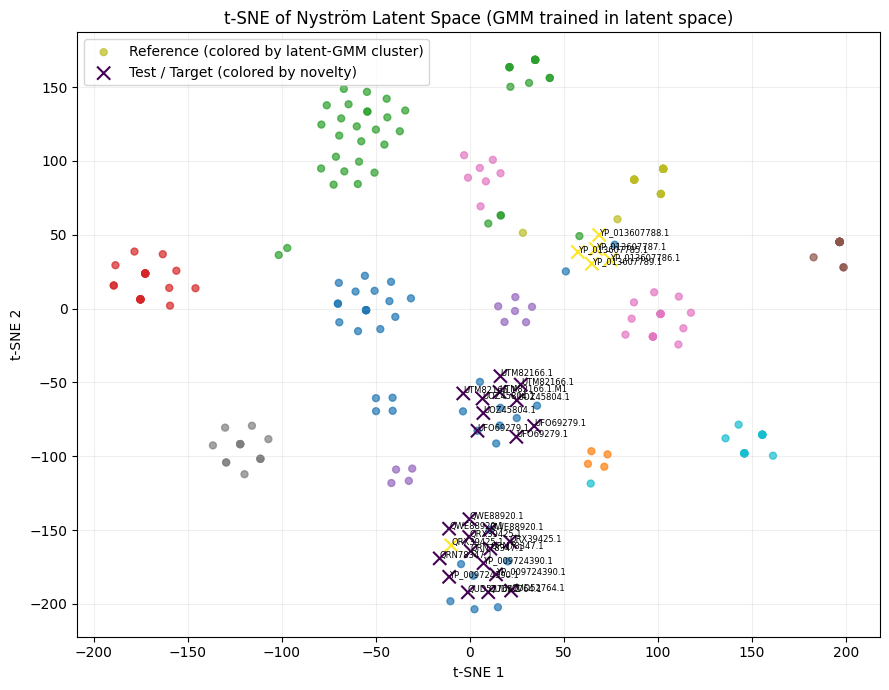

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=min(20, X.shape[1]), random_state=42)
Z_pca = pca.fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=20,
    init="pca",
    learning_rate="auto",
    method="barnes_hut",
    random_state=42,
)
X_2d = tsne.fit_transform(Z_pca)

X_ref_2d = X_2d[:Z_ref.shape[0]]
X_test_2d = X_2d[Z_ref.shape[0]:]


plt.figure(figsize=(9, 7))
plt.scatter(
    X_ref_2d[:, 0],
    X_ref_2d[:, 1],
    c=ref_cluster,
    cmap="tab10",
    s=25,
    alpha=0.7,
    label="Reference (colored by latent-GMM cluster)"
)

plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=p_novel,
    marker="x",
    s=90,
    label="Test / Target (colored by novelty)"
)

for i in range(len(X_test_2d)):
    plt.text(X_test_2d[i, 0], X_test_2d[i, 1], test_ids[i], fontsize=6)

plt.title("t-SNE of Nyström Latent Space (GMM trained in latent space)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()